In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
#from source.utils import *
from source.classes import *
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm

# Set up and design project

In [3]:
with open('../../Desktop/DLC_social_1/DLC_social_1_exp_conditions.pickle', 'rb') as handle:
    Treatment_dict = pickle.load(handle)

In [4]:
#Which angles to compute?
bp_dict = {'B_Nose':['B_Left_ear','B_Right_ear'],
          'B_Left_ear':['B_Nose','B_Right_ear','B_Center','B_Left_flank'],
          'B_Right_ear':['B_Nose','B_Left_ear','B_Center','B_Right_flank'],
          'B_Center':['B_Left_ear','B_Right_ear','B_Left_flank','B_Right_flank','B_Tail_base'],
          'B_Left_flank':['B_Left_ear','B_Center','B_Tail_base'],
          'B_Right_flank':['B_Right_ear','B_Center','B_Tail_base'],
          'B_Tail_base':['B_Center','B_Left_flank','B_Right_flank']}

In [5]:
%%time
DLC_social_1 = project(path='../../Desktop/DLC_social_1/',#Path where to find the required files
                   smooth_alpha=0.85,                    #Alpha value for exponentially weighted smoothing
                   distances=['B_Center','B_Nose','B_Left_ear','B_Right_ear','B_Left_flank',
                              'B_Right_flank','B_Tail_base'],
                   ego='B_Center',
                   angles=True,
                   connectivity=bp_dict,
                   arena='circular',                  #Type of arena used in the experiments
                   arena_dims=[380],                  #Dimensions of the arena. Just one if it's circular
                   video_format='.mp4',
                   table_format='.h5',
                   exp_conditions=Treatment_dict)

CPU times: user 2.7 s, sys: 772 ms, total: 3.48 s
Wall time: 1.21 s


# Run project

In [6]:
%%time
DLC_social_1_coords = DLC_social_1.run(verbose=True)
print(DLC_social_1_coords)
type(DLC_social_1_coords)

Loading trajectories...
Smoothing trajectories...
Computing distances...
Computing angles...
Done!
Coordinates of 47 videos across 4 conditions
CPU times: user 10.2 s, sys: 803 ms, total: 11 s
Wall time: 13 s


source.classes.coordinates

# Generate coords

In [7]:
%%time
ptest = DLC_social_1_coords.get_coords(center=True, polar=False, speed=0)
ptest._type

CPU times: user 806 ms, sys: 61.8 ms, total: 868 ms
Wall time: 820 ms


'coords'

In [8]:
%%time
dtest = DLC_social_1_coords.get_distances(speed=0)
dtest._type

CPU times: user 23.2 ms, sys: 14.3 ms, total: 37.5 ms
Wall time: 36.6 ms


'dists'

In [9]:
%%time
atest = DLC_social_1_coords.get_angles(degrees=True, speed=0)
atest._type

CPU times: user 107 ms, sys: 68.8 ms, total: 175 ms
Wall time: 175 ms


'angles'

# Visualization playground

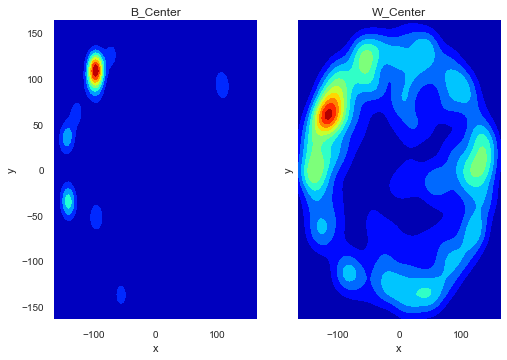

In [10]:
ptest.plot_heatmaps(['B_Center', 'W_Center'], i=1)

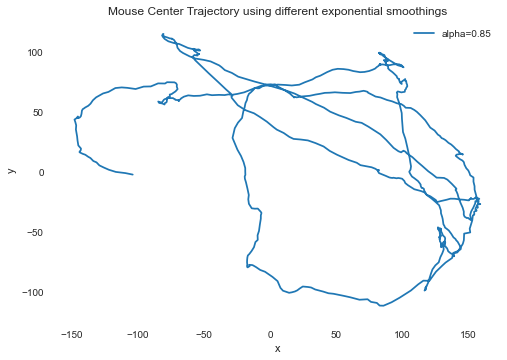

In [11]:
#Plot animation of trajectory over time with different smoothings
plt.plot(ptest['Day2Test13DLC']['B_Center'].loc[:1000]['x'],
         ptest['Day2Test13DLC']['B_Center'].loc[:1000]['y'], label='alpha=0.85')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Mouse Center Trajectory using different exponential smoothings')
plt.legend()
plt.show()

# Dimensionality reduction playground

In [12]:
pca = ptest.pca(4, 1000)

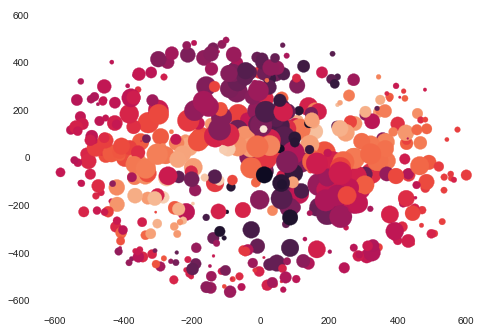

In [13]:
plt.scatter(*pca[0].T)
plt.show()

# Preprocessing playground

In [14]:
mtest = merge_tables(DLC_social_1_coords.get_coords(center=True, polar=True),
                 DLC_social_1_coords.get_distances(speed=0),
                 DLC_social_1_coords.get_angles(degrees=True, speed=2))

In [15]:
ptest = mtest.preprocess(window_size=51, filter='gaussian', sigma=10, shift=20)

In [16]:
ttest = mtest.preprocess(window_size=51, filter=None)

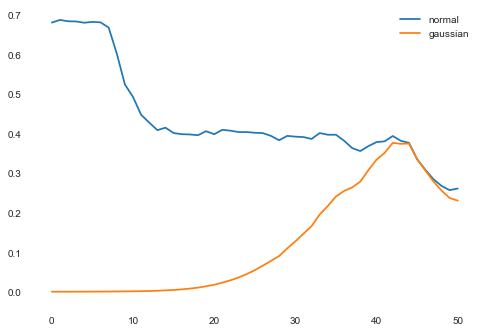

In [17]:
plt.plot(ttest[2,:,2], label='normal')
plt.plot(ptest[2,:,2], label='gaussian')
plt.legend()
plt.show()